# Semi-definite integrals with Gauss-Laguerre quadrature

For the multilayer finite dipole method (FDM), we need to calculate the electric potential and field induced at a surface by a charge $q$ using the integrals
$$
\begin{align*}
  \phi &= \int_0^\infty \beta(k) e^{-2 z_q k} dk, \text{ and}\\
  E_z &= \int_0^\infty \beta(k) k e^{-2 z_q k} dk,
\end{align*}
$$
where $k$ is the in-plane momentum, $\beta(k)$ is the effective surface reflection coefficient, and $z_q$ is the height of the charge above the surface.

`scipy.integrate.quad_vec` can perform infinite integrals, but it can't be compiled using `numba`, which means it can't be called from within other `numba`-compiled functions.
I want to find a way to evaluate the integrals without relying on `scipy.integrate.quad_vec`.

## Gauss-Laguerre quadrature

Gauss-Laguerre quadrature is a version of Gaussian quadrature which evaluates exponentially weighted integrals according to
$$
\int_0^{\infty} e^{-x} f(x) dx \approx \sum_{n=1}^N w_n f(x_n),
$$
where $x_n$ is the $n^{th}$ root of the Laguerre polynomial
$$
L_N(x) = \sum_{n=0}^{N} {N \choose n} \frac{(-1)^n}{n!} x^n,
$$
and $w_n$ is a weight given by
$$
w_n = \frac{x_n}{\left((N + 1) L_{N+1}(x_n) \right)^2}.
$$

Evaluating the roots and weights can be complicated, but thankfully numpy has a function `numpy.polynomial.laguerre.laggauss(deg)`, which returns `(x, y)`, the roots and weights of the Laguerre polynomial for $N=$ `deg`.

## Adapting the integrals

To convert the integrals to the needed form, we can use the substitution $x = 2 z_q k$, so that
$$
\begin{align*}
  \phi
  & = \frac{1}{2 z_q} \int_0^\infty \beta\left(\frac{x}{2 z_q}\right) e^{-x} dx, \text{ and}\\
  E_z
  & = \frac{1}{4 z_q^2} \int_0^\infty \beta\left(\frac{x}{2 z_q}\right) x e^{-x} dx.
\end{align*}
$$

We can then evaluate the integrals with the approximations
$$
\begin{align*}
  \phi
  & \approx \frac{1}{2 z_q} \sum_{n=1}^N w_n \beta\left(\frac{x_n}{2 z_q}\right), \text{ and}\\
  E_z
  & \approx \frac{1}{4 z_q^2} \sum_{n=1}^N w_n \beta\left(\frac{x_n}{2 z_q}\right) x_n.
\end{align*}
$$

In [49]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from numba import njit
from tqdm import tqdm
import finite_dipole as fdm


# Define my functions
def phi_full(z_q, beta_k):
    phi, _ = quad_vec(lambda k: beta_k(k) * np.exp(-2 * k * z_q), 0, np.inf)
    return phi


def phi_rescaled(z_q, beta_k):
    phi, _ = quad_vec(lambda x: beta_k(x / (2 * z_q)) * np.exp(-x), 0, np.inf)
    return phi / (2 * z_q)


@njit
def phi_integrand(x, z_q, beta_k):
    return beta_k(x / (2 * z_q)) * np.exp(-x)


def phi_fast(z_q, beta_k):
    phi, _ = quad_vec(lambda x: phi_integrand(x, z_q, beta_k), 0, np.inf)
    return phi / (2 * z_q)


@njit
def phi_GL(z_q, beta_k, x_n, w_n):
    return (w_n * beta_k(x_n / (2 * z_q))).sum() / (2 * z_q)


def E_full(z_q, beta_k):
    E, _ = quad_vec(lambda k: beta_k(k) * k * np.exp(-2 * k * z_q), 0, np.inf)
    return E


def E_rescaled(z_q, beta_k):
    E, _ = quad_vec(lambda x: beta_k(x / (2 * z_q)) * x * np.exp(-x), 0, np.inf)
    return E / (4 * z_q**2)


@njit
def E_integrand(x, z_q, beta_k):
    return beta_k(x / (2 * z_q)) * x * np.exp(-x)


def E_fast(z_q, beta_k):
    E, _ = quad_vec(lambda x: E_integrand(x, z_q, beta_k), 0, np.inf)
    return E / (4 * z_q**2)

@njit
def E_GL(z_q, beta_k, x_n, w_n):
    return (w_n * beta_k(x_n / (2 * z_q)) * x_n).sum() / (4 * z_q**2)


# Define charge height and sample parameters
z_q = 20e-9
eps_stack = 1, 1.52 + 0.83j, 13.7  # e.g. Air, PMMA, Si
middle_thickness = 50e-9
beta_k = fdm.reflection.refl_coeff_ML(eps_stack=eps_stack, t_stack=(middle_thickness,))


First let's verify that the rescaled integrals produce the same results as the full versions.

In [50]:
np.testing.assert_allclose(phi_full(z_q, beta_k), phi_rescaled(z_q, beta_k))
np.testing.assert_allclose(E_full(z_q, beta_k), E_rescaled(z_q, beta_k))
    

Now lets compare how the parameter N affects the accuracy of the integral.

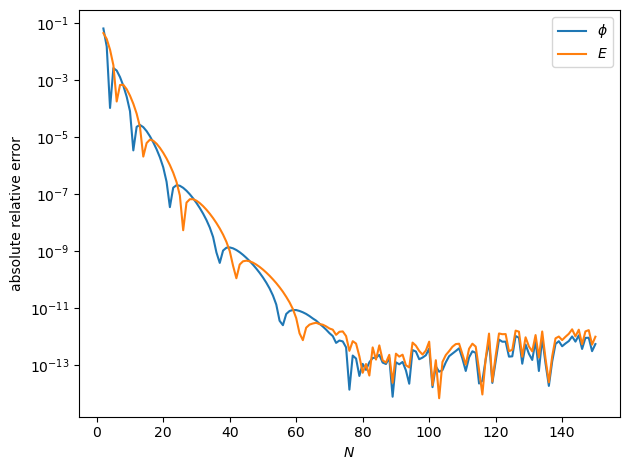

In [51]:
N_test = np.arange(2, 151)

phi_true = phi_rescaled(z_q, beta_k)
E_true = E_rescaled(z_q, beta_k)

phi_est = np.zeros_like(N_test, dtype=complex)
E_est = np.zeros_like(N_test, dtype=complex)
for i, N in enumerate(N_test):
    x_n, w_n = np.polynomial.laguerre.laggauss(N)
    phi_est[i] = phi_GL(z_q, beta_k, x_n, w_n)
    E_est[i] = E_GL(z_q, beta_k, x_n, w_n)

fig, ax = plt.subplots()
ax.plot(N_test, np.abs(1 - np.abs(phi_est / phi_true)), label=r"$\phi$")
ax.plot(N_test, np.abs(1 - np.abs(E_est / E_true)), label=r"$E$")
ax.set(xlabel=r"$N$", ylabel=r"absolute relative error", yscale="log")
ax.legend()
fig.tight_layout()
plt.show()


Now let's test the speed for each algorithm to run after compiling them with `numba`.
For the sake of a fair comparison I'll use a version of the functions where the integrand for `scipy.integrate.quad_vec` has also been precompiled.

Running 149 by 1000 evals: 100%|██████████| 149/149 [00:03<00:00, 41.37it/s]


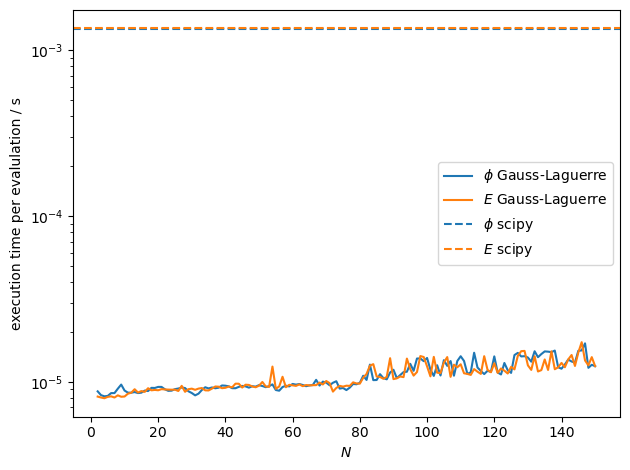

In [52]:
def time_function(f, N_reps):
    start = time.perf_counter()
    _ = [f() for _ in range(N_reps)]
    return (time.perf_counter() - start) / N_reps


N_test = np.arange(2, 151)
N_reps = 1000

phi_scipy_time = time_function(lambda: phi_fast(z_q, beta_k), N_reps)
E_scipy_time = time_function(lambda: E_fast(z_q, beta_k), N_reps)

phi_time = np.empty_like(N_test, dtype=float)
E_time = np.empty_like(N_test, dtype=float)
for i, N in enumerate(tqdm(N_test, desc=f"Running {N_test.size} by {1000} evals")):
    x_n, w_n = np.polynomial.laguerre.laggauss(N)
    phi_time[i] = time_function(lambda: phi_GL(z_q, beta_k, x_n, w_n), N_reps)
    E_time[i] = time_function(lambda: E_GL(z_q, beta_k, x_n, w_n), N_reps)

fig, ax = plt.subplots()
c_phi, c_E = "C0", "C1"
ls_GL, ls_scipy = "-", "--"
ax.plot(N_test, phi_time, label=r"$\phi$ Gauss-Laguerre", c=c_phi, ls=ls_GL)
ax.plot(N_test, E_time, label=r"$E$ Gauss-Laguerre", c=c_E, ls=ls_GL)
ax.axhline(phi_scipy_time, label=r"$\phi$ scipy", c=c_phi, ls=ls_scipy)
ax.axhline(E_scipy_time, label=r"$E$ scipy", c=c_E, ls=ls_scipy)
ax.set(xlabel=r"$N$", ylabel=r"execution time per evalulation / s", yscale="log")
ax.legend()
fig.tight_layout()
plt.show()
